In [1]:
import string
import numba as nb
nb.config.NUMBA_NUM_THREADS = 10
from numba import njit, prange

import scipy.io

import numpy as np
import random
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from io import StringIO
from scipy.spatial.distance import cosine
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import gensim
import multiprocessing
import gensim.models.keyedvectors as w2v
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
mat = scipy.io.loadmat('recipe2-emd_tr_te_split.mat', appendmat=False)

In [4]:
mat_tr = mat['TR']

mat_te = mat['TE']

mat_words = mat['the_words']

mat_bow = mat['BOW_X']

mat_x = mat['X']

mat_y = mat['Y']

mat_y = mat_y-1

In [5]:
docs = []
for i in tqdm(range(len(mat_words[0]))):
#     print(i)
    sent = []
    try:
        for w in mat_words[0][i][0]:
            sent.append(w[0])
        docs.append(sent)
    except IndexError:
        continue

In [6]:
def long_words(text):
    text = [t for t in text if len(t) >= 2]
    return text

docs = [long_words(sen) for sen in docs]

In [8]:
for i in range(len(mat_tr)):
    random.Random(49).shuffle(mat_tr[i])
    
for i in range(len(mat_te)):
    random.Random(49).shuffle(mat_te[i])


In [9]:
data_full = [' '.join(t) for t in docs]

X_train = []
y_train = []
X_test = []
y_test = []
for kfold in range(len(mat_tr)): 
    X_train.append([ data_full[i-1] for i in mat_tr[kfold] ])
    y_train.append([ mat_y[0][j-1] for j in mat_tr[kfold] ])
    
for kfold in range(len(mat_te)):
    X_test.append([ data_full[i-1] for i in mat_te[kfold] ])
    y_test.append([ mat_y[0][j-1] for j in mat_te[kfold] ])
    
classes = len(np.unique(y_train))

In [10]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [11]:
def word_sent_emb(corpus):

    sentence_embedding = []
    sent_vecs_sum = []
    word_emb = []
    new_corpus = []

    for text in tqdm(corpus):

        # Add the special tokens.
        marked_text = "[CLS] " + text + " [SEP]"
        
        # Split the sentence into tokens.
        tokenized_text = tokenizer.tokenize(marked_text)

        if len(tokenized_text) >= 512:
            end = int(len(tokenized_text)-256)
            del tokenized_text[256:end]

        # Map the token strings to their vocabulary indeces.
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        
        # Mark each of the 22 tokens as belonging to sentence "1".
        segments_ids = [1] * len(indexed_tokens)
        
        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])
        
        # Predict hidden states features for each layer
        with torch.no_grad():
            encoded_layers, _ = model(tokens_tensor, segments_tensors)
        
        # Concatenate the tensors for all layers. We use `stack` here to
        # create a new dimension in the tensor.
        token_embeddings = torch.stack(encoded_layers, dim=0)

        # Remove dimension 1, the "batches".
        token_embeddings = torch.squeeze(token_embeddings, dim=1)

        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,0,2)

            # Stores the token vectors, with shape [30 x 768]
        token_vecs_sum = []

        # `token_embeddings` is a [30 x 12 x 768] tensor.
        # For each token in the sentence...
        for token in token_embeddings:

            # `token` is a [12 x 768] tensor
            # Sum the vectors from the last four layers.
            sum_vec = torch.sum(token[-4:], dim=0)
            # Use `sum_vec` to represent `token`.
            token_vecs_sum.append(sum_vec)
    #     sent_vecs_sum.append(token_vecs_sum)

        d = {} 
        words = {}
        separator = 1
        for t in range(len(tokenized_text)):
            d[t] = token_vecs_sum[t]
            words[t] = tokenized_text[t]
            if '##' in tokenized_text[t]:
                d[t-separator] = (token_vecs_sum[t] + d[t-separator])/2
                words[t-separator] = words[t-separator] + tokenized_text[t]
                words[t-separator] = ''.join(filter(str.isalpha,  words[t-separator]))
                del d[t]
                del words[t]
                separator += 1
            else:
                separator = 1   
        word_emb.append(list(d.values())[1:-1])      # excluding CLS and SEP
        new_corpus.append(list(words.values())[1:-1])

#     #    ****** Version 1 of extracting sentence embedding, 
#     #     `encoded_layers` has shape [12 x 1 x 22 x 768]
#     #     `token_vecs` is a tensor with shape [22 x 768]
#         token_vecs = encoded_layers[11][0]    
#     #     Calculate the average of all token vectors.
#         sentence_embedding.append(torch.mean(token_vecs, dim=0))

    # #    ****** Version 2
    #     token_vecs = encoded_layers[0][:,0,:]  # First layer is CLS     [all sentences, only the first token CLS, all layers]
    #     sentence_embedding.append(token_vecs)
    
    return [word_emb, new_corpus]

In [12]:
bert_tr = [ word_sent_emb(corpx) for corpx in X_train[:1]]
bert_ts = [ word_sent_emb(corpy) for corpy in X_test[:1]]

In [13]:
X_train_bert = bert_tr[0][1]
X_test_bert = bert_ts[0][1]

In [14]:
bert_trB = bert_tr[0][0]
bert_tsB = bert_ts[0][0]

In [15]:
# COnvert every tensor (=word=vector) to numpy
bert_trB = [[x.numpy().astype(np.float32) for x in y] for y in bert_trB]
bert_tsB = [[x.numpy().astype(np.float32) for x in y] for y in bert_tsB]

In [17]:
def weights_tfidf(doci, indexed):
    
    w_tfidf = []
    for i in range(len(doci)):
        doc = doci[i]
        w = np.zeros(len(doc))
        for j in range(len(doc)):
            w[j] = indexed[i].get(doc[j])
        w_tfidf.append(w)
        
    return w_tfidf

In [18]:
train_fullB = [' '.join(t) for t in X_train_bert]
test_fullB = [' '.join(t) for t in X_test_bert]


tfidf_vec = TfidfVectorizer()
transformed_trainB = tfidf_vec.fit_transform(raw_documents=train_fullB)
index_value_trainB = {i[1]:i[0] for i in tfidf_vec.vocabulary_.items()}

tfidf_vecT = TfidfVectorizer()
transformed_testB = tfidf_vecT.fit_transform(raw_documents=test_fullB)
index_value_testB = {i[1]:i[0] for i in tfidf_vecT.vocabulary_.items()}


fully_indexed_trainB = []
for row in transformed_trainB:
    fully_indexed_trainB.append({index_value_trainB[column]:value for (column,value) in zip(row.indices,row.data)})

fully_indexed_testB = []
for rowt in transformed_testB:
    fully_indexed_testB.append({index_value_testB[columnT]:valueT for (columnT,valueT) in zip(rowt.indices,rowt.data)})
    
    
w_tfidfTrainB = weights_tfidf(X_train_bert, fully_indexed_trainB)
w_tfidfTestB = weights_tfidf(X_test_bert, fully_indexed_testB)


wtrain_idfB = [w/max(w) for w in w_tfidfTrainB]
wtest_idfB = [z/max(z) for z in w_tfidfTestB]

In [19]:
# classes = len(np.unique(y_train[0]))
@nb.njit()
def weight_inverse(k, sim):
    result = np.zeros(k)
    summ = 0.0
    for i in range(k):
        result[i] += 1.0 / (sim[i]**2+1)
        summ += result[i]
    result = 1 - result/summ
    return result

# @nb.njit(parallel=True)
def knn(sim, k, y):
    ordering = sim.argsort()[::-1]    # sort ind of similarities from max to min
    k_near_dists = sim[ordering]      # choose k largest similarities
    votes = np.zeros(classes)
    wts = weight_inverse(k, k_near_dists)   # get weight for similarities
    for j in nb.prange(k):
        idx = ordering[j]
        pred_class = np.int(y[idx])     # take labels of max to min
        votes[pred_class] += wts[j] * 1.0
    return np.argmax(votes)

In [20]:
@njit(inline='always')
def cosine_similarity_numba(u, v):
#     assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
        
    return cos_theta

@nb.njit(parallel=True)
def calc_dis(word_vectors_ts, word_vectors_tr):
    word_matrix = np.zeros((len(word_vectors_ts), len(word_vectors_tr)))
    
    for vec1 in nb.prange(len(word_vectors_ts)):
        for vec2 in range(len(word_vectors_tr)):
            word_matrix[vec1,vec2] = cosine_similarity_numba(word_vectors_ts[vec1], word_vectors_tr[vec2])
            
    return word_matrix

In [57]:
from numba import jit, njit
from numba.types import float64, int64
import numpy as np

@jit(float64[:](float64[:], int64, float64[:]),nopython=True)
def rnd1(x, decimals, out):
    return np.round_(x, decimals, out)

In [60]:
@nb.njit()
def cross_similarity_new(similarity_matrix, col_weights, row_weights, similarity_threshold, P,neg_ts,neg_tr,idx_ts,idx_tr):
    n_rows = len(row_weights)        # test
    n_cols = len(col_weights)        # train
    assert(similarity_matrix.shape == (n_rows,n_cols))
    complete_connection = 0
    true_connection = 0

    for i in nb.prange(n_rows):
        complete_connection += (row_weights[i]*col_weights[idx_ts[i]])*(similarity_matrix[i,idx_ts[i]])*neg_ts[i]
        for j in range(n_cols):
            if i == 0:
                complete_connection += (row_weights[idx_tr[j]]*col_weights[j])*(similarity_matrix[idx_tr[j],j])*neg_tr[j]

            if similarity_matrix[i,j] >= similarity_threshold:
                true_connection += (row_weights[i]*col_weights[j])*(P + similarity_matrix[i,j])

    if complete_connection > 0:
        connection_value = true_connection/complete_connection
    else:
        connection_value = 0
    
    return connection_value
    
    
@nb.njit() 
def sim_new(M, w_tr, w_ts, eps, P, sigm):
    
    max_ts = np.array([np.amax(M[m,:]) for m in range(M.shape[0])])                  # test
    # max value from each word (index) in sent1 to words (values in list) in sent2
    indmax_ts = [np.where(M[m,:] == max_ts[m])[0][0] for m in range(M.shape[0])] 
    max_tr = np.array([np.amax(M[:,n]) for n in range(M.shape[1])])                  # train
    indmax_tr = [np.where(M[:,n] == max_tr[n])[0][0] for n in range(M.shape[1])]
    
    # find which max similarities are out of one sigma
    find_ts = (max_ts - np.mean(max_ts) + sigm*np.std(max_ts))                     # for test
    find_tr = (max_tr - np.mean(max_tr) + sigm*np.std(max_tr))                     # for train
    
    # maximum similarity of words in sent1 is significant in regards to words in sent2
    y1=np.empty_like(find_ts)
    y2=np.empty_like(find_tr)
    neg_ts = (rnd1(find_ts, 10, y1) >= 0)*1  
    neg_tr = (rnd1(find_tr, 10, y2) >= 0)*1  
                
        
    relations = []
    for i in range(len(indmax_ts)):
        relations.append((i,indmax_ts[i]))

    for j in range(len(indmax_tr)):
        if (indmax_tr[j],j) in relations:       
            neg_tr[j] = 0                # for train
    
    score = cross_similarity_new(M, w_tr, w_ts, eps, P, neg_ts, neg_tr, indmax_ts, indmax_tr)

    return score


def result_new(m, n, k, eps, P, bert_embTr, bert_embTs, w_tr, w_ts, y_train, y_test, sigm):
    y_predict = []
    sims = np.zeros(m*n)
    for i in tqdm(range(m)):  # compare one test doc with all training docs to find the closest
        for j in range(n):
            M = calc_dis(bert_embTs[i], bert_embTr[j])
            sims[(i*n)+j] = sim_new(M, w_tr[j], w_ts[i], eps, P, sigm)
        y_class = knn(sims[i*n:(i+1)*n], k, y_train)
        y_predict.append(y_class)

    f1score = f1_score(y_test[:m], y_predict, average='micro')
#     print(classification_report(y_test[:m], y_predict, digits=3))
    
    return f1score

In [46]:
def new_sim_sep(m, n, eps, P, corp2bert_train, corp2bert_test, wc_d, wc_t, sigm):
    
    sims = np.zeros(m*n)
    
    for i in tqdm(range(m)):  # compare one test doc with all training docs to find the closest
        for j in range(n):
            M = calc_dis(corp2bert_test[i], corp2bert_train[j])
            sims[(i*n)+j] = sim_new(M, wc_d[j], wc_t[i], eps, P, sigm)
            
    return sims


def knn_sep(m, n, k, arr, y_train, y_test):
    
    y_predict = []
    
    for i in range(m):  # compare one test doc with all training docs to find the closest
        y_class = knn(arr[i*n:(i+1)*n], k, y_train)
        y_predict.append(y_class)
        
    f1score = f1_score(y_test[:m], y_predict, average='micro')       
#     print(classification_report(y_test[:m], y_predict, digits=3))
    
    return f1score

In [24]:
# Get number of words in each sentence
word_num_train = [[len(w) for w in corp] for corp in X_train]
word_num_test = [[len(w) for w in corp] for corp in X_test]

In [25]:
# Add zero at the beginning, for calculations
word_num_train_0 = [ [0]+corp for corp in word_num_train]
word_num_test_0 = [ [0]+corp for corp in word_num_test]

In [26]:
# All words from all sentences to one list keeping the order
bert_words_tr = [w1 for subl1 in X_train[0] for w1 in subl1]
bert_words_ts = [w2 for subl2 in X_test[0] for w2 in subl2]

In [27]:
# All vectors from all seentences to one list keeping the order
word_vectors_tr = [v1 for subv1 in bert_tr for v1 in subv1]
word_vectors_ts = [v2 for subv2 in bert_ts for v2 in subv2]

In [28]:
bert_trB = [np.array(x) for x in bert_trB]
bert_tsB = [np.array(x) for x in bert_tsB]

### p

In [38]:
m = 200
n = 400
k = 10
pp = np.arange(-10,2)*0.1
eps = 0.84
listP = []

for P in pp:
    listP.append(result_new(m, n, k, eps, P, bert_trB, bert_tsB, wtrain_idfB, wtest_idfB, y_train[0], y_test[0], 1))

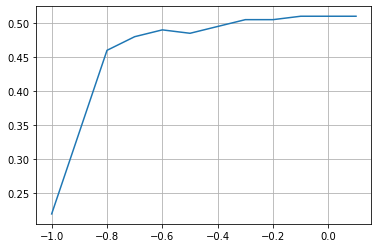

In [39]:
plt.plot(pp,listP)
plt.grid()

### Epsilon

In [62]:
m = 200
n = 400
k = 10
P = 0
Eps = np.arange(50,99,2)*0.01
listE = []

for eps in Eps:
    listE.append(result_new(m, n, k, eps, P, bert_trB, bert_tsB, wtrain_idfB, wtest_idfB, y_train[0], y_test[0], 1))

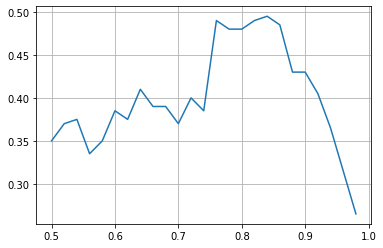

In [63]:
plt.plot(Eps, listE)
plt.grid()

### sigma

In [65]:
m = 200
n = 400
k = 10
P = 0
sigma = np.arange(2,12)*0.1
eps = 0.84
listSig = []

for sig in sigma:
    listSig.append(result_new(m, n, k, eps, P, bert_trB, bert_tsB, wtrain_idfB, wtest_idfB, y_train[0], y_test[0], sig))

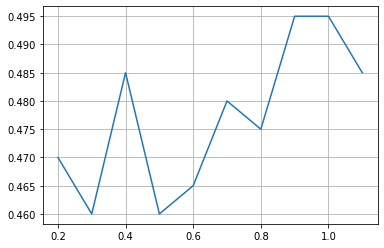

In [66]:
plt.plot(sigma, listSig)
plt.grid()

### Total

In [67]:
m = len(bert_tsB)
n = len(bert_trB)
P = 0
eps = 0.84
sigm = 0.99

arr_total_new = new_sim_sep(m, n, eps, P, bert_trB, bert_tsB, wtrain_idfB, wtest_idfB, sigm)

In [68]:
m = len(bert_tsB)
n = len(bert_trB)
K = np.arange(2,50)
listK_total = []

for k in K:
    listK_total.append(knn_sep(m, n, k, arr_total_new, y_train[0], y_test[0]))

In [70]:
np.max(listK_total)

0.5728451563691839

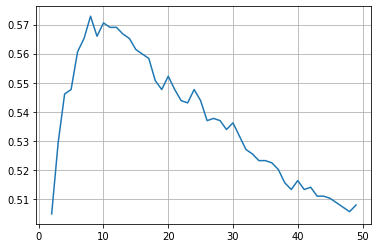

In [69]:
plt.plot(K, listK_total)
plt.grid()

# Bert + cos

In [51]:
# @nb.njit
def bert_similarity(part1, part2):
    vec1 = sum(part1) / len(part1)
    vec2 = sum(part2) / len(part2)
    sim = 1 - cosine(vec1, vec2)

    return sim 


def result_bench(m, n, k, corp2bert_train, corp2bert_test, y_train, y_test):

    y_predict = []
    sims = np.zeros(m*n)
    
    for i in tqdm(range(m)):  # compare one test doc with all training docs to find the closest
        for j in range(n):
            sims[(i*n)+j] = bert_similarity(corp2bert_train[j], corp2bert_test[i])
        y_class = knn(sims[i*n:(i+1)*n], k, y_train)
        y_predict.append(y_class)

    f1score = f1_score(y_test[:m], y_predict, average='micro')       
#     print(classification_report(y_test[:m], y_predict))
    
    return f1score

In [52]:
def bench_sim_sep(m, n, corp2bert_train, corp2bert_test):
    
    sims = np.zeros(m*n)
    
    for i in tqdm(range(m)):  # compare one test doc with all training docs to find the closest
        for j in range(n):
            sims[(i*n)+j] = bert_similarity(corp2bert_train[j], corp2bert_test[i])
            
    return sims


def knn_sep(m, n, k, arr, y_train, y_test):
    
    y_predict = []
    
    for i in range(m):  # compare one test doc with all training docs to find the closest
        y_class = knn(arr[i*n:(i+1)*n], k, y_train)
        y_predict.append(y_class)
        
    f1score = f1_score(y_test[:m], y_predict, average='micro')       
#     print(classification_report(y_test[:m], y_predict, digits=3))
    
    return f1score

# Total

In [53]:
m = len(bert_tsB)
n = len(bert_trB)

arr_bench = bench_sim_sep(m, n, bert_trB, bert_tsB)

In [54]:
m = len(bert_tsB)
n = len(bert_trB)
K = np.arange(2,50)
res_bench = []

for k in K:
    res_bench.append(knn_sep(m, n, k, arr_bench, y_train[0], y_test[0]))

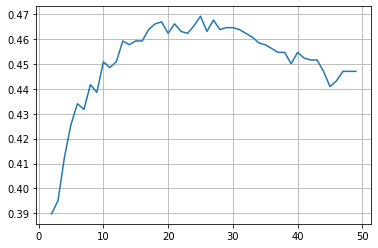

In [55]:
plt.plot(K, res_bench)
plt.grid()

In [56]:
np.max(res_bench)

0.4691075514874142